# GLM - Exercises

#### Exercise 1

Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5, 10, 20, 40, 80, 160, 320, 640). Compute the Pearson correlation between true and estimated receptive fields for each duration to quantify the accuracy of the (ML) estimator.

As the response generation process is stochastic, compute the average across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true receptive field?
_____

**ANS.:**

From the last plot, we find that the longer the duration of the stimulus, the higher is the Pearson correlation. However, there's a saturation point. After durations of approximately 100 seconds, the correlation does not improve further. I believe this is due to the fact that for smaller stimulus presentation times, not enough information has been collected for a good reconstruction of the filter. So the longer we present it, the better is its reconstruction. However, there's only so much information to collect such that after some point we are effectivrly collecting redundant information.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
def Gabor_filter(vf_size, sigma):
# CONSTRUCT THE FILTER - GROUND TRUTH
    mu = (8,8)
    angle, phase, frequency = 45, 0, 0.085
    
    xx, yy = np.meshgrid(1 + np.arange(vf_size[0]), 1 + np.arange(vf_size[1]))
    # Gaussian envelope
    G = np.exp( -(xx - mu[0])**2 / (2 * sigma[0]) - (yy - mu[1])**2 / (2 * sigma[1]))
    # Spatial modulation
    phi = np.deg2rad(angle)
    xxr = xx * np.cos(phi)
    yyr = yy * np.sin(phi)
    xyr = (xxr + yyr) * (2 * np.pi) * 2 * frequency
    Sn = np.cos(xyr + phase)

    K = G * Sn
    K /= np.max(np.abs(K))

    return K

def simulate_linear_response(duration,sigma, dt=0.1, std_dev=1, vf_size = (15,15)):

    # CONSTRUCT THE DESIGN MATRIX
    n_bins = int(duration / dt)
    S = std_dev * np.random.randn(n_bins, vf_size[0], vf_size[1])

    K = Gabor_filter(vf_size, sigma)
    
    # SIMULATE NEURON'S RESPONSE
    noise_variance, offset = 1, 2
    
    K_flat = K.ravel()                   
    K_flat = np.hstack((K.flat, offset)) 

    S_flat = S.reshape(S.shape[0], S.shape[1] * S.shape[2]) 
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))       

    ks = K_flat @ S_flat.T    
    r = ks                   
    r = r + np.sqrt(noise_variance) * np.random.randn(n_bins)

    return r, S_flat, vf_size, K

def reconstruct_filter(r, S_flat, vf_size):
    K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ r)
    K_hat = K_hat[:-1].reshape(vf_size)
    return K_hat

def pearson_correlation(k, k_estimate):
    k_flat, k_estimate_flat = k.ravel(), k_estimate.ravel()
    pc = (k_flat @ k_estimate_flat) / (np.linalg.norm(k_flat) * np.linalg.norm(k_estimate_flat))
    return pc

In [3]:
durations = np.array([5, 10, 20, 40, 80, 160, 320, 640])
# Finner durations 
#durations = np.arange(10,601,10)
trials_per_duration = 10

pearsons = np.zeros((len(durations), trials_per_duration))

for i, duration in enumerate(durations):    
    for trial in range(trials_per_duration):
        r, S_flat, vf_size, K = simulate_linear_response(duration, (4,4))
        K_estimate = reconstruct_filter(r, S_flat, vf_size)
        pearsons[i, trial] = pearson_correlation(K, K_estimate)      
    
    '''print(duration)
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.title('Prediction')
    plt.imshow(K_estimate, cmap='summer')

    plt.subplot(1,2,2)
    plt.title('Ground truth')
    plt.imshow(K, cmap='summer')

    plt.show()'''

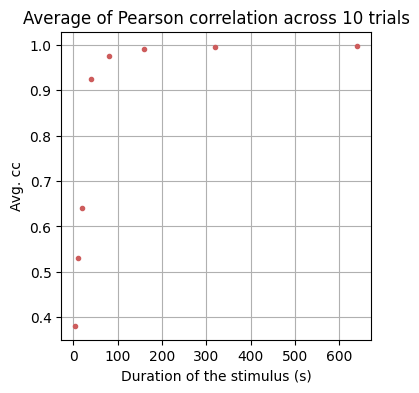

In [4]:
avg_pearsons = np.mean(pearsons, axis=1)

# PLOT
plt.figure(figsize=(4,4))
plt.title('Average of Pearson correlation across {} trials'.format(trials_per_duration))
plt.plot(durations, avg_pearsons, '.', color='indianred')
plt.xlabel('Duration of the stimulus (s)')
plt.ylabel('Avg. cc')
plt.grid()

#### Exercise 2

Determine the effect of the response noise on the receptive field. To do so, try different values of the noise variance in the simulations ([0,2,4,6,8,10]) for a duration of 100 ms. As in the previous exercise, repeatedly estimate the RF parameters for each condition 10 times but also plot the standard deviation of the correlations across different runs for each condition.
_____

**ANS.:**

Increasing $\sigma$ (more or less) means increasing the area covered by the filter, i.e., it is the same as increasing the region to which the neuron responds to the stimulus. Intuitively, then, we understand why increasing the size of this region should also increase the PC. Covering a wider region of the visual field means that more information can be collected and used to reconstruct the filter (*). On that same note, small $\sigma$'s show a higher standard deviation which is due to the fact that such a small region ot the visual field is more susceptible to variation as it does not have contributions of the surroudings!


(*) This isn't as linear as I am stating here. There have been advancements, particularly from the computational neuroscience part, that show the such wide regions of the visual field are integrated by higher regions of the brain rather than single neurons. A sparser coding of the visual field is prefered.

In [5]:
sigmas = [(0.1,0.1),(1,1),(2,2),(3,3),(4,4),(5,5),(6,6),(7,7),(8,8),(9,9),(10,10)]
ss = [0.1,1,2,3,4,5,6,7,8,9,10]

pearsons = np.zeros((len(sigmas), trials_per_duration))
for i, sigma in enumerate(sigmas):    
    for trial in range(trials_per_duration):
        r, S_flat, vf_size, K = simulate_linear_response(100, sigma)
        K_estimate = reconstruct_filter(r, S_flat, vf_size)
        pearsons[i, trial] = pearson_correlation(K, K_estimate)  

    '''print(sigma)
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.title('Prediction')
    plt.imshow(K_estimate, cmap='summer')

    plt.subplot(1,2,2)
    plt.title('Ground truth')
    plt.imshow(K, cmap='summer')

    plt.show()'''

avg_pearsons = np.mean(pearsons, axis = 1)
std_pearsons = np.std(pearsons, axis = 1)

Text(0.5, 1.0, 'Average standard deviation across 10 trials')

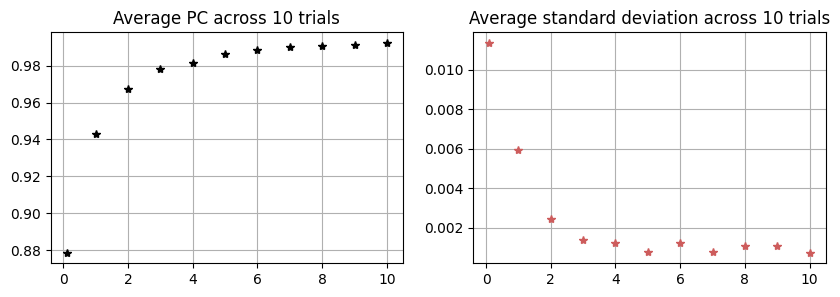

In [6]:
plt.figure(figsize = (10,3))

plt.subplot(1,2,1)
plt.plot(ss, avg_pearsons, '*k')
plt.grid()
plt.title('Average PC across {} trials'.format(trials_per_duration))

plt.subplot(1,2,2)
plt.plot(ss, std_pearsons, '*', color='indianred')
plt.grid()
plt.title('Average standard deviation across {} trials'.format(trials_per_duration))

#### Exercise 3

Look at the analytiacl derivation of the log-likelihhod for the Poisson GLM. Which of the terms are required for maximizing the likelihhod w.r.t. $\bm{k}$ and which terms can be ignored?

**Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier. 
_____

**ANS.:**

The likelihood of a neuron's response $r_t$ at time instant $t$ is given by the Poisson p.d.f. Because we assumed that spike times are independent from one another, the probability of the neuron's response for the whole spike sequence is simply

$$P(R|\lambda) = \prod_{t=1}^N P(r_t|\lambda_t)$$

As usual, we work with log-likelihood which yields 

$$log\ P(R|\lambda) = \sum_{t=1}^N log\ P(r_t|\lambda_t) = \sum_{t=1}^N (r_t\log \lambda_t + r_t\log \Delta - \log r_t! - \lambda_t \Delta) $$

Only the $\lambda_t$ term has dependence on $\bm{k}$ so upon differentiation all other terms will yield zero and recall we are interested in the maximum of the log likelihood which is the same as the minimum of minus the log likelihood, meaning we can write

$$-log\ P(R|\lambda) = \sum_{t=1}^N (r_t\log \lambda_t - \lambda_t \Delta) =  -\sum_{t=1}^N r_t (\bm{k}\cdot\bm{s}_t) +  \Delta\sum_{t=1}^N  e^{(\bm{k}\cdot\bm{s}_t)}$$

where we used the fact that $\lambda_t = e^{\bm{k} \cdot \bm{s}_t}$. The maximum likelihood estimator $\hat{\bm{k}}$ is given by taking the derivative of $log\ P(R|\lambda)$ w.r.t. $\bm{k}$ which gives

$$\frac{\partial{\log P}}{\partial{\bm{k}}} = \frac{\partial }{\partial\bm{k}} \left[\sum_{t=1}^N (r_t (\bm{k}\cdot\bm{s}_t) - e^{(\bm{k}\cdot\bm{s}_t)} \Delta)\right] = -\sum_t r_t s_t + \Delta\sum_t s_t\ e^{(\bm{k}\cdot\bm{s}_t)}$$

#### Exercise 4

Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

1. Generate data with duration (10, 20, 50, 100, 200) seconds. Fit the model on each dataset and plot the fitted parameters, using the PC as a proxy for the goodness of fit and plot it as a function of the duration.

2. Fix the duration to 100 ms and change the average firing rate. How does the fit perform for different firing rates?

_____

**ANS.:**

In [7]:
from scipy.optimize import minimize

def generate_inhomogeneous_poisson_spike_times(lamba, dt):
    
    '''lambda: Firing rate function'''
    
    #n_bins = lamba.shape[0]
    n_bins = len(lamba)
    bins = np.arange(n_bins + 1) * dt

    # Generate Poisson distributed numbers for each of the bins
    # with the maximum rate/intensity/lambda    
    lamba_max = np.max(lamba)
    poisson_numbers = np.random.poisson(lamba_max, size = n_bins)

    # Throw away numbers depending on the actual intensity ('thinning')
    spike_times = []
    prob = lamba / lamba_max
    
    for i in range(n_bins):

        # Number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))

        # Generate random spike times in this bin
        ts = bins[i] + np.random.rand(n_s) * dt
        
        spike_times.extend(ts)

    return np.asarray(spike_times)

def n_loglikelihood(k, spike_counts, S, dt):
    r = spike_counts 
    ks = k @ S.T
    lamba = np.exp(ks)
    return - r @ ks + dt * np.sum(lamba) 

def simulate_non_linear_response(duration, spike_rate, dt = 0.1, std_dev = 1, vf_size = (15,15) ):
    
    n_bins = round(duration / dt)
    S = std_dev * np.random.randn(n_bins, vf_size[0], vf_size[1])
    K = Gabor_filter(vf_size, (4,4))

    K_flat = K.ravel()
    K_flat = np.hstack((K_flat, 2))

    S_flat = S.reshape(S.shape[0], S.shape[1] * S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

    # Linear stage
    ks = K_flat @ S_flat.T

    # Nonlinear stage
    lamba = np.exp(ks)

    expected_rate = np.sum(lamba * dt) / duration 
    lamba *= (spike_rate / expected_rate)

    spike_times = generate_inhomogeneous_poisson_spike_times(lamba, dt)

    spike_counts = np.histogram(spike_times,
                                bins = np.arange(n_bins + 1) * dt)[0]
    
    return spike_times, spike_counts, S_flat, K

def reconstruct_filter_poisson(spike_counts, S_flat, dt):
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = n_loglikelihood, x0 = k_STA / 10, args = (spike_counts, S_flat, dt))
    K_est = res.x
    return K_est

def pearsons_ex4(k, k_estimate):
    kk = k.ravel()
    kke = k_estimate[:-1]
    ans = np.inner(kk, kke) / (np.linalg.norm(kk) * np.linalg.norm(kke))
    return ans

10


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\3385504427.py:36: RuntimeWarning: overflow encountered in exp
  lamba = np.exp(ks)
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\3385504427.py:36: RuntimeWarning: overflow encountered in exp
  lamba = np.exp(ks)
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


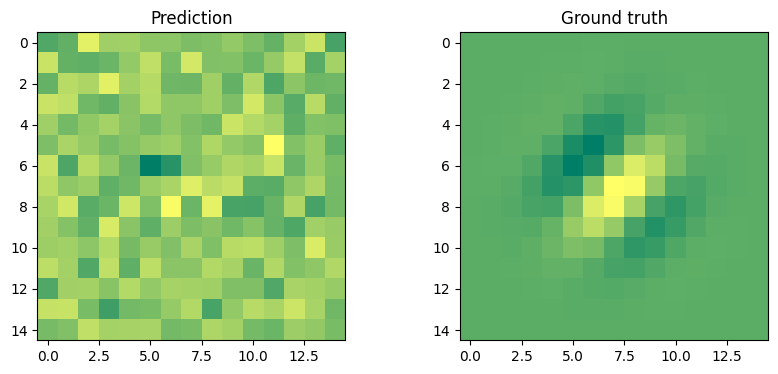

20


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\3385504427.py:36: RuntimeWarning: overflow encountered in exp
  lamba = np.exp(ks)
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\3385504427.py:36: RuntimeWarning: overflow encountered in exp
  lamba = np.exp(ks)
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\3385504427.py:36: RuntimeWarning: overflow encountered in exp
  lamba = np.exp(ks)
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\3385504427.py:36: RuntimeWarning: overflow encountered in exp
  lamba = np.exp(ks)
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\338550442

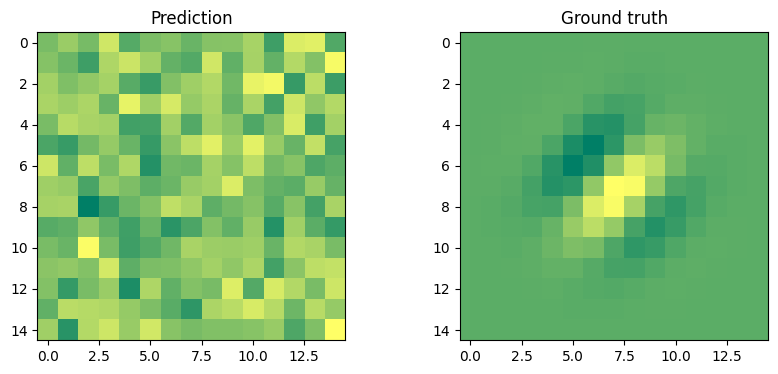

50


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\3385504427.py:36: RuntimeWarning: overflow encountered in exp
  lamba = np.exp(ks)
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\3385504427.py:36: RuntimeWarning: overflow encountered in exp
  lamba = np.exp(ks)
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\3385504427.py:36: RuntimeWarning: overflow encountered in exp
  lamba = np.exp(ks)
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\3385504427.py:36: RuntimeWarning: overflow encountered in exp
  lamba = np.exp(ks)
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\338550442

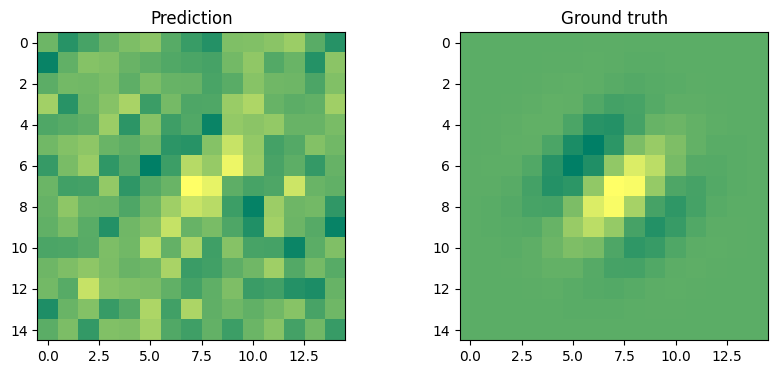

100


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\3385504427.py:36: RuntimeWarning: overflow encountered in exp
  lamba = np.exp(ks)
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\3385504427.py:36: RuntimeWarning: overflow encountered in exp
  lamba = np.exp(ks)


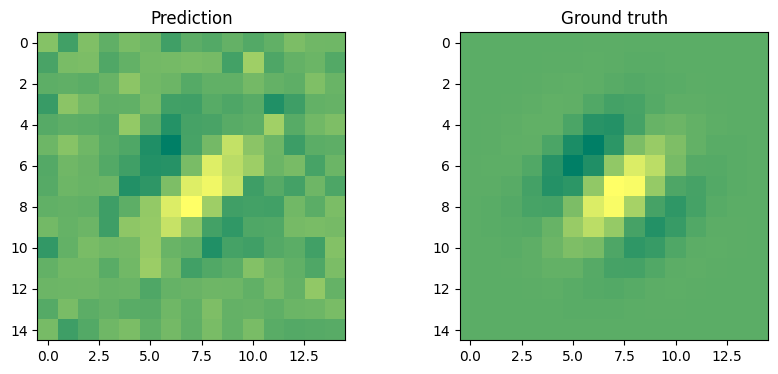

200


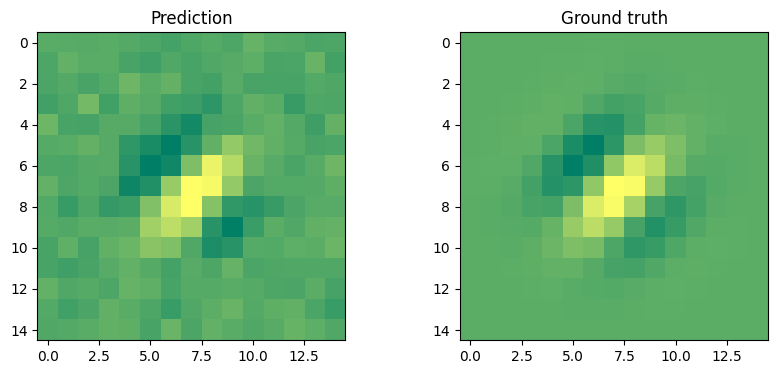

In [8]:
durations = [10,20,50,100,200]
#durations = [100,200]
pearsons = np.zeros((len(durations), trials_per_duration))

for i, duration in enumerate(durations): 
    print(duration)   
    for trial in range(trials_per_duration):
        spike_times, spike_counts, S_flat, K = simulate_non_linear_response(duration,5)
        K_estimate = reconstruct_filter_poisson(spike_counts, S_flat, 0.1)
        pearsons[i, trial] = pearsons_ex4(K, K_estimate)
    
    
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.title('Prediction')
    plt.imshow(K_estimate[:-1].reshape(15, 15), cmap='summer')

    plt.subplot(1,2,2)
    plt.title('Ground truth')
    plt.imshow(K, cmap='summer')

    plt.show()

1


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\3385504427.py:36: RuntimeWarning: overflow encountered in exp
  lamba = np.exp(ks)
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


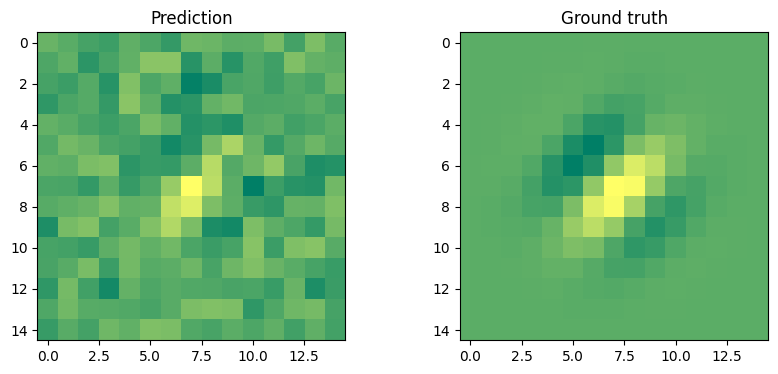

5


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\3385504427.py:36: RuntimeWarning: overflow encountered in exp
  lamba = np.exp(ks)
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\3385504427.py:36: RuntimeWarning: overflow encountered in exp
  lamba = np.exp(ks)
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\3385504427.py:36: RuntimeWarning: overflow encountered in exp
  lamba = np.exp(ks)
c:\Users\Utilizador\Desktop\Master's\4th Quarter\NA\NA_git_env\.venv\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13108\3385504427.py:36: RuntimeWarning: overflow encountered in exp
  lamba = np.exp(ks)


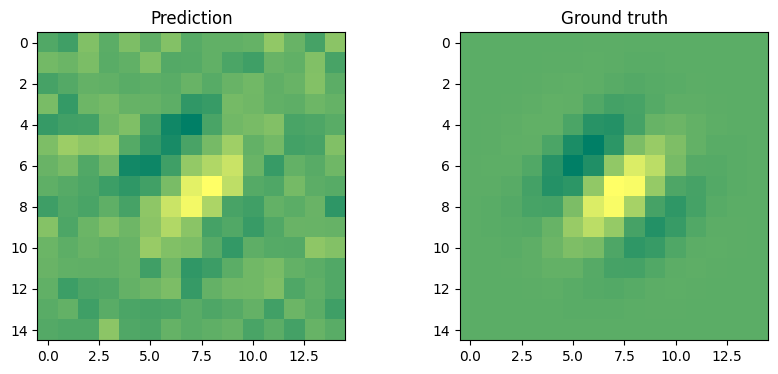

10


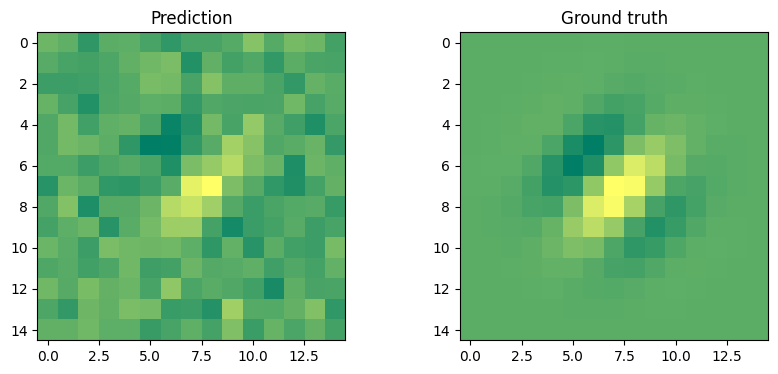

20


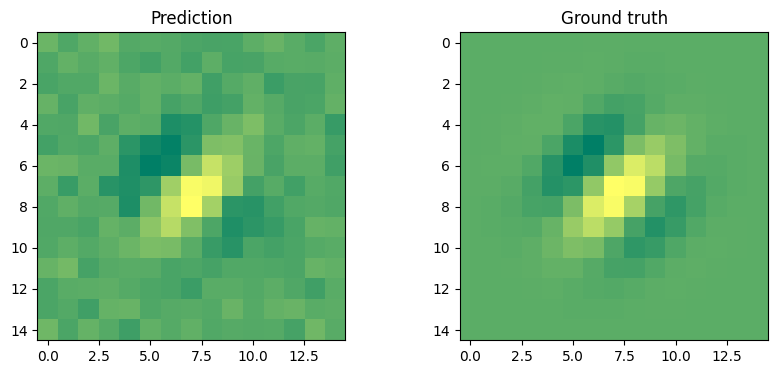

100


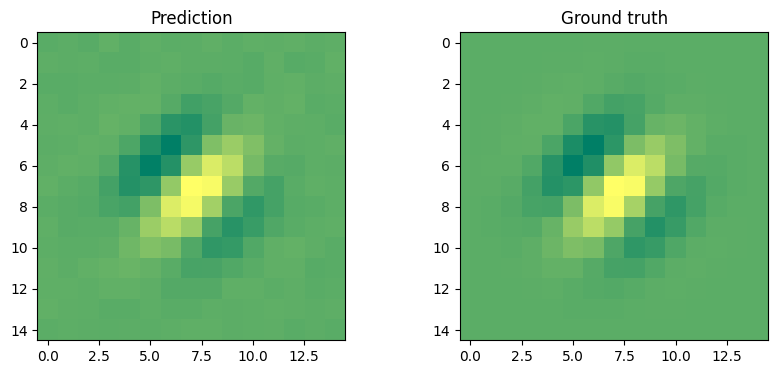

In [9]:
spike_rates = [1,5,10,20,100]

for i, spike_rate in enumerate(spike_rates): 
    print(spike_rate)   
    for trial in range(trials_per_duration):
        spike_times, spike_counts, S_flat, K = simulate_non_linear_response(100,spike_rate)
        K_estimate = reconstruct_filter_poisson(spike_counts, S_flat, 0.1)
        pearsons[i, trial] = pearsons_ex4(K, K_estimate)
    
    
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.title('Prediction')
    plt.imshow(K_estimate[:-1].reshape(15, 15), cmap='summer')

    plt.subplot(1,2,2)
    plt.title('Ground truth')
    plt.imshow(K, cmap='summer')

    plt.show()